# Single DK rumour spreading model


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum

class State(Enum):
    SPREADER = 0 # People actively spreading the rumour
    IGNORANT = 1 # People who haven't encountered the rumour
    STIFLER = 2 # People who have heard the rumour but are not spreading it

TIME_STEPS = 25
POPULATION_SIZE = 4039
CLIQUISHNESS = 44

ACTIVENESS = 0.1
RUMOUR_ACCEPTANCE_PROB = 0.2
SPREADER_SPREADER_STIFLE_PROB = 0.2
SPREADER_STIFLER_STIFLE_PROB = 0.1
FORGET_PROB = 0.01

In [2]:
class DKModel:
    def __init__(self, graph, initial_rumour_spreaders: int) -> None:
        self.graph = graph

        # Initialize states
        self.states = {node: State.IGNORANT for node in graph.nodes}
        infected_nodes = np.random.choice(graph.nodes, initial_rumour_spreaders, replace=False)
        for node in infected_nodes:
            self.states[node] = State.SPREADER

        # History tracking
        self.s_history = []
        self.i_history = []
        self.r_history = []

    def step(self) -> None:
        new_states = self.states.copy()

        for node in self.graph.nodes:
            if self.states[node] == State.SPREADER:
                neighbors = list(self.graph.neighbors(node))

                for neighbor in neighbors:
                    if np.random.random() > ACTIVENESS:
                        continue

                    # If neighbour is ignorant
                    if self.states[neighbor] == State.IGNORANT:
                        if np.random.random() < RUMOUR_ACCEPTANCE_PROB:
                            new_states[neighbor] = State.SPREADER
                        elif np.random.random() < 1 - RUMOUR_ACCEPTANCE_PROB:
                            new_states[neighbor] = State.STIFLER
                    # If neighbour is a spreader
                    elif self.states[neighbor] == State.SPREADER:
                        if np.random.random() < SPREADER_SPREADER_STIFLE_PROB:
                            new_states[neighbor] = State.STIFLER
                        if np.random.random() < SPREADER_SPREADER_STIFLE_PROB:
                            new_states[node] = State.STIFLER
                    # If neighbour is a stifler
                    elif self.states[neighbor] == State.STIFLER:
                        if np.random.random() < SPREADER_STIFLER_STIFLE_PROB:
                            new_states[node] = State.STIFLER

            # Random chance to become an ignorant again
            if np.random.random() < FORGET_PROB:
                new_states[node] = State.IGNORANT
                continue

        self.states = new_states

        # Count states
        spreaders = list(self.states.values()).count(State.SPREADER)
        ignorants = list(self.states.values()).count(State.IGNORANT)
        stiflers = list(self.states.values()).count(State.STIFLER)

        self.s_history.append(spreaders)
        self.i_history.append(ignorants)
        self.r_history.append(stiflers)

    def draw(self) -> None:
        plt.figure(figsize=(10, 6))

        # Assemble colour map
        colours = []
        for node in self.graph.nodes:
            if self.states[node] == State.SPREADER:
                colours.append('red')
            elif self.states[node] == State.IGNORANT:
                colours.append('blue')
            elif self.states[node] == State.STIFLER:
                colours.append('green')

        nx.draw(self.graph, node_size=50, node_color=colours, with_labels=False)
        plt.title('DK Model of Rumor Propagation on a Graph')
        plt.show()

    def run(self, time_steps: int, draw=False) -> None:
        for _ in range(time_steps):
            if draw:
                self.draw()
            self.step()
        if draw:
            self.draw()

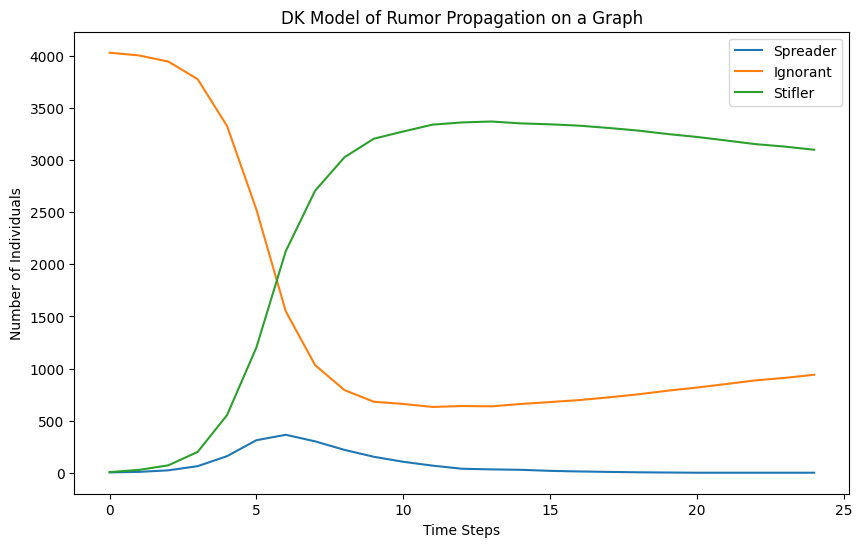

In [8]:
graph = nx.barabasi_albert_graph(POPULATION_SIZE, CLIQUISHNESS)
dk_model = DKModel(graph, initial_rumour_spreaders=1)
dk_model.run(TIME_STEPS, draw=False)

plt.figure(figsize=(10, 6))
plt.plot(dk_model.s_history, label='Spreader')
plt.plot(dk_model.i_history, label='Ignorant')
plt.plot(dk_model.r_history, label='Stifler')
plt.title('DK Model of Rumor Propagation on a Graph')
plt.xlabel('Time Steps')
plt.ylabel('Number of Individuals')
plt.legend()
plt.show()

